# Julia programming language

Julia is compiled "just in time". This means that when you first run a piece of code it complies first and then runs it. This means that the first time your run a piece of code it will take longer than the next time you run it. Before we begin we will install all the packages we need to solve the ODE model, perform the paraemter esimtation, and visualise the results. Start this code at the start of the lecture as it may take some minutes to run. 

In [54]:
# This code will activate the package environment by reading the Project.toml file in this directory
# and then instantiate the environment by installing all the packages in the environment.
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating project at `c:\Users\20195166\OneDrive - TU Eindhoven\Documents\Indentifiability`


In [55]:
# We will now load the packages that we will use in this notebook

# For solving differential equations
using OrdinaryDiffEq

# CairoMakie is a powerful plotting library that is built on top of Makie.jl
using CairoMakie

# Random is used for generating random numbers
using Random

# QuasiMonteCarlo is used for generating initial parameters with Latin Hypercube Sampling
using QuasiMonteCarlo

# Optimization is used for optimization
using Optimization

# For Profile Likelihood
using Distributions

# We also use some utility functions that will help us
include("utils/SelectionMethods.jl")

evaluate_and_select (generic function with 2 methods)


*Note:* If you get the following error message:
```julia
ERROR: LoadError: ArgumentError: Package XXX not found in current path
```

Please make sure that you have indeed installed the packages by running the cell above. If you have done so, please check in the bottom left corner of the Jupyter Notebook in
Visual Studio Code that you have selected the correct Julia environment. You can do this by clicking on the `Julia env` button and selecting the `VITAL_Trainschool_Prep` environment. Then, restart the Notebook by clicking on the `Restart` button on top of the Notebook.


# The Eindhoven Diabetes Education Simulator

The Eindhoven Diabetes Education Simulator (EDES) is physiology-based mathematical model describing the systemic interplay between glucose and insulin. The EDES model describes the rate of appeance of ingested glucose via the gut, the secretion of endogenous glucose from the liver, and both insulin dependent and independent uptake into the peripheral tissues. The EDES model also describes the secretion of insulin in response to changes in plasma glucose using a PD (proportional-derivative) controller. The EDES model consits of four ordinary differential equations describing rate of change of glucose in the stomach (gut_glucose) and plasma (plasma_glucose) and insulin in the plasma (plasma_insulin) and interstitial compartment (interstitial_insulin) and contains 13 kinetic paraemters that have been estimated from literature to describe the average OGTT response. More detail on the mode equations and parameters can be found in the file "EDES_Explained.pdf". 

<img src="figures/EDES.png" width="400" height="400">

## Implementing the EDES model in Julia

First we will implement the ODE equations. Note the implementation of these equations looks very similar to a model in Matlab or Python. 

A slight difference you will notice is that we also have the derivative of the state variables as an input to the function. This is because for efficiency, we typically define the ODE function as a *mutating* function. This means that the function will modify the given array `du` in place, rather than returning a new array. This is done to avoid unnecessary memory allocations. The exact details of memory allocations are not important for most users, but for future reference, this is a common pattern seen in developer-level Julia code.

In [56]:
"""
edesode!(du, u, p, t)
  This function defines the system of ordinary differential equations (ODEs) that describe the EDES model.
"""
function edesode!(du, u, p, t)
  #specify initial values
    Ggut, Gpl, Ipl, Irem = u
    #specify the parameters
    k1, k2, k3, k4, k5, k6, k7, k8, k9, k10, tau_i, tau_d, beta, Gren, EGPb, Km, f, Vg, c1, sigma, Dmeal, bw, Gb, Ib = p
  
    # Equation defining rate of decay of ingested glucose in stomach/gut
    du[1] = sigma * k1^sigma * t^(sigma-1) * exp(-(k1*t)^sigma) * Dmeal - k2 * Ggut
  
    # Equation describing the rate of change of plasma glucose
    gliv = EGPb - k3 * (Gpl - Gb) - k4 * beta * Irem #Endogenous glucose production in liver
    ggut = k2 * (f / (Vg * bw)) * Ggut #glucose appearing from meal
    u_ii =  EGPb * ((Km + Gb)/Gb) * (Gpl / (Km + Gpl)) # insulin independent uptake of glucose to peripheral tissues
    u_id = k5 * beta * Irem * (Gpl / (Km + Gpl)) # insulin dependent uptake of glucose to peripheral tissues
    u_ren = c1 / (Vg * bw) * (Gpl - Gren) * (Gpl > Gren) # renal excretion of excess glucose (>Gren threshold)
  
    du[2]  = gliv + ggut - u_ii - u_id - u_ren #full glucose in plasma equation
  
    #  Equation describing the rate of change of plasma insulin
    i_pnc = beta^(-1) * (k6 * (Gpl - Gb) + (k7 / tau_i) * Gb + k8 * tau_d * du[2]) #rate of insulin production in pancreas (funtion of glucose)
    i_liv = k7 * Gb * Ipl / (beta * tau_i * Ib) #rate of insulin degredation by liver
    i_int = k9 * (Ipl - Ib) #rate of insulin transport to interstitial compartment
    du[3] = i_pnc - i_liv - i_int # full insulin in plasma equation
    du[4] = i_int - k10 * Irem #full insulin in instertital compartment equation
end

edesode!

The we will specify model inputs (body weight, fasting glucose and insulin values, and the amount of glucose in the meal), model parameter values (all kinetic parameters and model constants), and initial values (initial fasting values of each state variable) and build the ODE problem

In [57]:
# specify physiology parameters
bw = 70.0 #body weight (kg)
Gb = 5.0 #fasting glucose (mmol/l)
Ib = 10.0 #fasting insulin (uIU/ml)

# meal parameters
Dmeal = 75.0e3 #amount of glucose in meal (mg)

# specify the values for the EDES model parameters
k1 = 0.0105   # rate of glucose decay in stomach
k2 = 0.28     # rate of glucose transport from stomach to plasma
k3 = 6.07e-3  # rate of glucose effect on endogenous glucose production
k4 = 2.35e-4  # rate of insulin effect on endogenous glucose production
k5 = 0.0424   # rate of insulin dependent glucose uptake into peripheral tissues
k6 = 2.2975   # rate of insulin secretion (proportional to Gb)
k7 = 1.15     # rate of insulin secretion (integral of Gpl)
k8 = 7.27     # rate of insulin secretion (derivative of Gpl)
k9 = 3.83e-2  # delay parameter plasma to insterstitial insulin
k10 = 2.84e-1 # rate constant for degredation of insulin in remote compartment
tau_i = 31.0  # time delay integrator function
tau_d = 3.0   # time delay 
beta = 1.0    # conversion factor insulin
Gren = 9.0    # threshold for renal excretion of glucose
EGPb = 0.043  # basal rate of endogenous glucose production
Km = 13.2     # Michealis Menten coeficient for glucose uptake into periphery
f = 0.005551  #
Vg = 17.0 / bw # volume of distribution for glucose (function of body weight)
c1 = 0.1      # model constant
sigma = 1.4   # shape factor (appearance of meal)

# define the collection of parameters
p = [k1, k2, k3, k4, k5, k6, k7, k8, k9, k10, tau_i, tau_d, beta, Gren, EGPb, Km, f, Vg, c1, sigma, Dmeal, bw, Gb, Ib]

# set initial conditions for each state variable 
# [glucose mass in gut, glcuose concentration in plasma, insulin concentration in plasma, insulin constration in instertitium]
u0 = [0.0, Gb, Ib, 0.0]

# set time span for model simulation
tspan = (0.0, 240.0)

# define the ODE problem
prob = ODEProblem(edesode!, u0, tspan, p)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
Non-trivial mass matrix: false
timespan: (0.0, 240.0)
u0: 4-element Vector{Float64}:
  0.0
  5.0
 10.0
  0.0

Finally, once we have defined the ODE problem and specified the model constants and parameters, and the intial values of each state variable we will solve the ODE problem and visualise the results. 

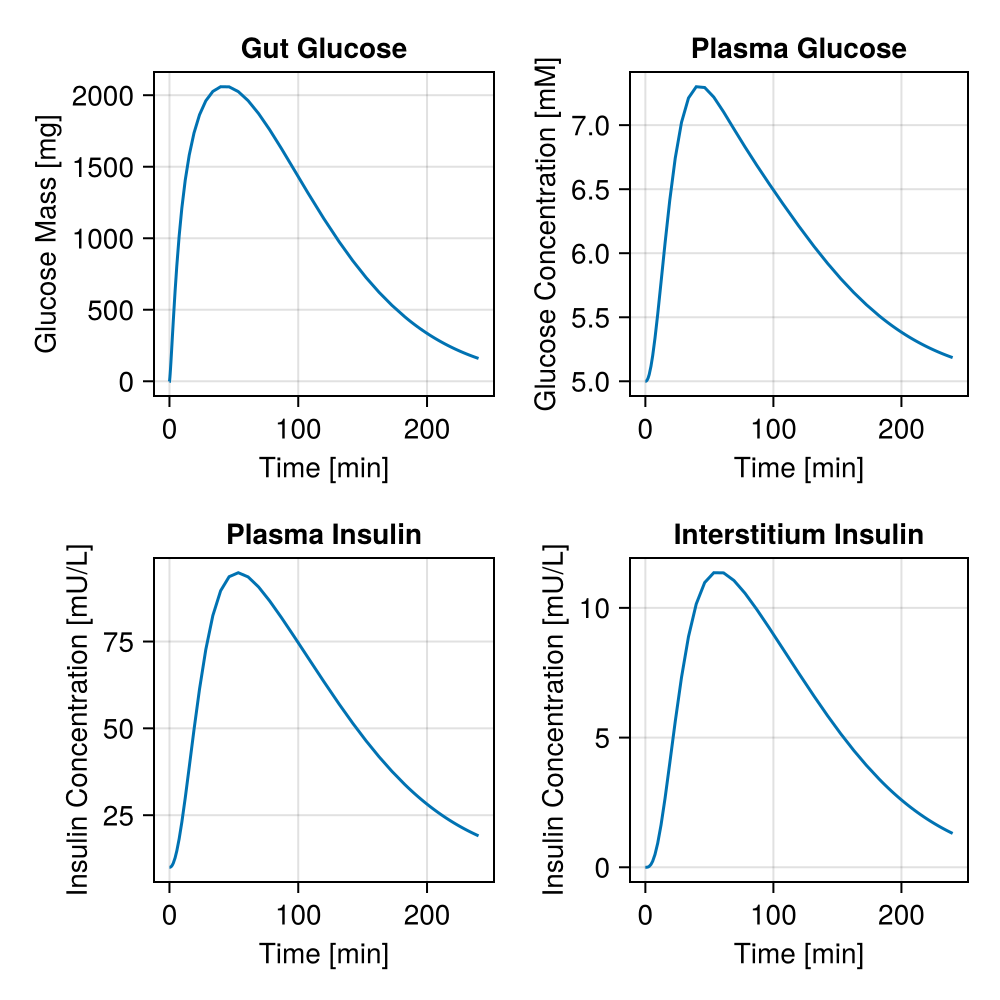

In [58]:
#solve the ODE problem using the solve function
solution = solve(prob)

# visualize the solution
solution_figure = let f = Figure(size=(500,500))

    ax_g_gut = Axis(f[1,1], xlabel="Time [min]", ylabel="Glucose Mass [mg]", title="Gut Glucose")
    ax_g_plasma = Axis(f[1,2], xlabel="Time [min]", ylabel="Glucose Concentration [mM]", title="Plasma Glucose")
    ax_i_plasma = Axis(f[2,1], xlabel="Time [min]", ylabel="Insulin Concentration [mU/L]", title="Plasma Insulin")
    ax_i_int = Axis(f[2,2], xlabel="Time [min]", ylabel="Insulin Concentration [mU/L]", title="Interstitium Insulin")
  
    lines!(ax_g_gut, solution.t, solution[1,:], color=Makie.wong_colors()[1])
    lines!(ax_g_plasma, solution.t, solution[2,:], color=Makie.wong_colors()[1])
    lines!(ax_i_plasma, solution.t, solution[3,:], color=Makie.wong_colors()[1])
    lines!(ax_i_int, solution.t, solution[4,:], color=Makie.wong_colors()[1])
  
  
    f
  end

## Parameter Estimation for EDES

Previous work by Erdos et al. has identified a four parameter EDES model, estimaing k1, k5, k6, and k8 from plasma trajectories of glucose and insulin following a meal as being the most parsimonious for generating personlised EDES models from experimental data. 
|parameter|function|
|---------|-------------------------|
| k1 | rate of glucose appearence from stomach|
| k5 | rate of insulin dependent glucose uptake into tissues|
| k6 | rate of insulin secretion in response to plasma glucose (proportional)|
| k8 | rate of insulin secretion in response to plasma glucose (derivative) |

The remaining parameters are fixed to the population average estimated in the origianl study. Below we will set up the EDES model for parameter estimation by first defining a function that specifies model parameters. 

In [59]:
#define a function that will specify parameters to be estimated and take in values for fixed parameters 
function construct_parameters(θ, c)

    # Estimated parameters
    k1 = θ[1]     # rate og glucose decay in stomach
    k5 = θ[2]     # rate of insulin dependent glucose uptake into peripheral tissues
    k6 = θ[3]     # rate of insulin secretion (proportional to Gb)
    k8 = θ[4]     # rate of insulin secretion (derivative of Gpl) #to fix the value for k8 you can change the value here (an example is provided below)
    
    # Fixed parameters
    k2 = c[1]     # rate of glcuose transport from stomach to plasma
    k3 = c[2]     # rate of glucose effect on endogenous glucose production
    k4 = c[3]     # rate of insulin effect on endogenous glucose production
    k7 = c[4]     # rate of insulin secretion (integral of Gpl)
    k9 = c[5]     # delay parameter plasma to insterstitial insulin
    k10 = c[6]    # rate constant for degredation of insulin in remote compartment
    tau_i = c[7]  # time delay integrator function
    tau_d = c[8]  # time delay 
    beta = c[9]   # conversion factor insulin
    Gren = c[10]  # threshold for renal excretion of glucose
    EGPb = c[11]  # basal rate of endogenous glucose production
    Km = c[12]    # Michealis Menten coeficient for glucose uptake into periphery
    f = c[13]     #
    Vg = c[14]    # volume of distribution for glucose (function of body weight)
    c1 = c[15]    # model constant
    sigma = c[16] # shape factor (appearance of meal)
    Dmeal = c[17] #amount of glucose in meal (mg)
    bw = c[18]    #body weight (kg)
    Gb = c[19]    #fasting glucose (mmol/l)
    Ib = c[20]    #fasting insulin (uIU/ml)
    return [k1, k2, k3, k4, k5, k6, k7, k8, k9, k10, tau_i, tau_d, beta, Gren, EGPb, Km, f, Vg, c1, sigma, Dmeal, bw, Gb, Ib]
  end

construct_parameters (generic function with 1 method)

We must also define a loss function. In this instance we define our loss function as the sum of square error between the measured plasma glucose and insulin concentrations and the model simulated glucose and insulin values for a given paramter set. The objective of the parameter estimation is to minimize the negative log likelihood of the data given the model. Assuming normally distributed error, we have:

$$ \text{NLL}(\theta | y) = n \log\left(\sigma_y \sqrt{2\pi} \right) + \frac{1}{2\sigma_y^2} \sum_{i=1}^n \left(y_i - f(t_i, \theta)\right)^2 $$

where $n$ is the number of data points, $\sigma_y$ is the standard deviation of the data, $y_i$ is the $i$th data point, $f(t_i, \theta)$ is the model output at time $t_i$ given parameters $\theta$. Here, we do this for both glucose and insulin, and do a weighted sum of the two likelihoods. In this case, we do not use different weights for glucose and insulin, but this is possible. 

Note that here we also assume we do not know the error of our data, so this is another parameter to estimate. We also assume homoskedasticity, i.e. that the error is the same for all data points, which will keep the optimization tractable.

In [60]:
#define our loss function
#
#loss function takes in values for the estimated parameter and a tuple containing the ODE problem name, values for the fixed parameters and model constants, and the measured experimetnal data. 
function loss(θ,(problem, constants ,data))
  #measured glucose and insulin data, including the sampling time points
    glucose_data = data[2,:]
    insulin_data = data[3,:]
    data_timepoints = data[1,:]

    #generate the full parameter vector by combining current values for the estimated parameters with the fixed values and constants.
    p = construct_parameters(θ, constants)

    # solve the ode problem for these parameter values, in this function we define the parameters as p
    # We also only save the ODE simulation at the timepoints that corrispond to the measured glucose and insulin data so we can calculate the error.
    # we also specify that of the four state varaibles [G_gut,  G_pl, I_pl, I_d] for calculating the error we are only interested in G_pl and I_pl 
    # we also specify the initial values (U0) for each state variable ([G_gut,G_pl,I_pl,I_d])  for the ODE solver
    pred = solve(problem, Tsit5(), p=p, saveat=data_timepoints, save_idxs=[2, 3], u0=[0.0, data[2,1], data[3,1], 0.0])
    sol = Array(pred)

    #calcualte the error between the measured glucose and insulin data and the EDES model simulation
    g_loss=(sol[1,:] - glucose_data)/maximum(glucose_data)
    i_loss=(sol[2,:] - insulin_data)/maximum(insulin_data)
    
    # likelihood for the glucose data
    n = length(glucose_data)
    σ_g = θ[end-1]
    L_g = n*log(σ_g * sqrt(2π)) + 1/(2σ_g^2) * sum(abs2, g_loss)

    # likelihood for the insulin data
    σ_i = θ[end]
    L_i = n*log(σ_i * sqrt(2π)) + 1/(2σ_i^2) * sum(abs2, i_loss)

    # weighted sum of the likelihoods
    return 0.5 * L_g + 0.5 * L_i
  end

loss (generic function with 1 method)

Now that we have defined our loss function we can estimate values for k1, k5, k6, and k8 from plasma glucose and insulin values measured during an oral glucose tolerance test. This test involved the ingestion of solution containing 75g of glucose. Measured glucose and insulin values are specified below.  

In [ ]:
#import measured glcuose and insulin data
#meal plasma glucose and insulin values collected during an OGTT
data_glu = [5.4 7.1 8.6 8.9 8.5 7.6 6.6]
data_ins = [7.9 36.7 64.8 75.6 79.6 80.5 68.7]
data_time = [0 15 30 45 60 90 120]
data = [data_time;data_glu;data_ins]
#plasma glucose and insulin values for individual A 
#To fit to the data for indivudal A uncomment these lines of code
#data_glu = [4.42 5.1 6.2 6.1 5.1 4.7 4.5]
#data_ins = [4.4 27.3 59.8 78.1 61.0 46.6 40.6]
#data_time = [0 15 30 45 60 90 120]
#data = [data_time;data_glu;data_ins]

#sepecify the fixed parameter values
constants = [k2, k3, k4, k7, k9, k10, tau_i, tau_d, beta, Gren, EGPb, Km, f, Vg, c1, sigma, Dmeal, bw, data_glu[1], data_ins[1]];

# plot of the data
data_figure = let f = Figure(size=(400,200))

    ax_glu = Axis(f[1,1], xlabel="Time [min]", ylabel="Concentration [mM]", title="Glucose Data")
    ax_ins = Axis(f[1,2], xlabel="Time [min]", ylabel="Concentration [mU/L]", title="Insulin Data")
  
    scatter!(ax_glu, data[1,:], data[2,:], color=Makie.wong_colors()[1])
    scatter!(ax_ins, data[1,:], data[3,:], color=Makie.wong_colors()[1])
  
    f
  end

To estimate model parameters we are using the limited-memory BFGS alogorithm (LBFGS), which is an optimisation algorithm in the family of quasi-Newton methods that approximates the Broyden-Fletcher-GoldFarb-Shanno algorithm . The LBFGS is a local optimiser. Consequently we run this algorithm several times using different parameter initialisations. To ensure we have a good coverage of the parameter space we use a latin-hypercube design. 

We first start with defining a function to generate some initial parameter guesses. We first generate samples using LatinHyperCube Sampling and then we make use of the `SelectionMethods.jl` utility file for some flexibility if we want to perform some filtering on the initial guesses. For now, we leave it to the default, which is to return all the samples.

In [61]:
function generate_initial_guesses(n_guesses, lower_bounds, upper_bounds; selection_method::SelectionMethod = SelectAll())

  initial_guesses = QuasiMonteCarlo.sample(n_guesses, lower_bounds, upper_bounds, LatinHypercubeSample())

  return evaluate_and_select(initial_guesses, selection_method)

end

generate_initial_guesses (generic function with 1 method)

Now we will perform the parameter generation and subsequent parameter estimation. The advantage of the speed of solvers in Julia means we can start with many parameter initialisations. Note how long it takes to run the parameter estimation proceedure for 1000 initial parameter sets

In [ ]:
# calcuate 1000 initial guesses for parameters being estimated using latin-hypercube design
initial_guess = generate_initial_guesses(1000, [0., 0., 0., 0., 1e-4, 1e-4], [1., 0.5, 5., 20., 100.0, 100.0])


results = []

optf = OptimizationFunction(loss, AutoForwardDiff())

# now run the local optimisation for each initial guess
#
# note: here it is not unusual to get errors or warnings as for some combinations of parameters generatined by the generate_initial_guesses function can induce errors in the ODE solver and/or
# the optimisation algorithm by reaching a tolerance that induces a stop. By making use of the try-catch fundtion the loop with catch the error and continute to the next initial guess. 
# This is also why we use many initial values, as we expect some parameter combinations to be unsuccessful. If you get an error for every parameter combination remove the try-catch and investigate
# if there is an error in your model code. 
for guess in eachcol(initial_guess)
    try
      res = solve(OptimizationProblem(optf, vec(guess), (prob, constants, data), lb = [0,0,0,0, 1e-4, 1e-4], ub=[1,0.5,10,25, 100, 100]), Optimization.LBFGS())
      push!(results, res)
    catch
      continue
    end
end;
# find the parameterisation with the lowest cost/objective funtion value
best_index = argmin([r.objective for r in results])
final = results[best_index].u

#solve the ODE problem using the solve function - to get the model simulation for this parameter set
solution = solve(prob, p =construct_parameters(final, constants), u0=[0.0, data[2,1], data[3,1], 0.0]);


┌ Warning: Unrecognized stop reason: ABNORMAL_TERMINATION_IN_LNSRCH                              . Defaulting to ReturnCode.Default.
└ @ Optimization C:\Users\20195166\.julia\packages\Optimization\qX4vR\src\utils.jl:93
┌ Warning: Unrecognized stop reason: ABNORMAL_TERMINATION_IN_LNSRCH                              . Defaulting to ReturnCode.Default.
└ @ Optimization C:\Users\20195166\.julia\packages\Optimization\qX4vR\src\utils.jl:93
┌ Warning: Unrecognized stop reason: ABNORMAL_TERMINATION_IN_LNSRCH                              . Defaulting to ReturnCode.Default.
└ @ Optimization C:\Users\20195166\.julia\packages\Optimization\qX4vR\src\utils.jl:93
┌ Warning: Unrecognized stop reason: ABNORMAL_TERMINATION_IN_LNSRCH                              . Defaulting to ReturnCode.Default.
└ @ Optimization C:\Users\20195166\.julia\packages\Optimization\qX4vR\src\utils.jl:93
┌ Warning: Unrecognized stop reason: ABNORMAL_TERMINATION_IN_LNSRCH                              . Defaulting to ReturnCode.

6×1000 Matrix{Float64}:
  0.7835    0.3015    0.0725    0.9925   …   0.2645    0.7445    0.7915
  0.08525   0.15125   0.49725   0.09275      0.16125   0.18525   0.12525
  0.0675    4.4575    0.0925    3.5625       0.2575    1.5425    2.3925
 17.27      7.47     16.33      7.39         4.91      1.17      8.55
 46.0501   82.45      2.2501   56.55        93.55     19.8501   44.1501
 91.85     66.55     15.1501   34.4501   …  52.75     74.75     17.8501

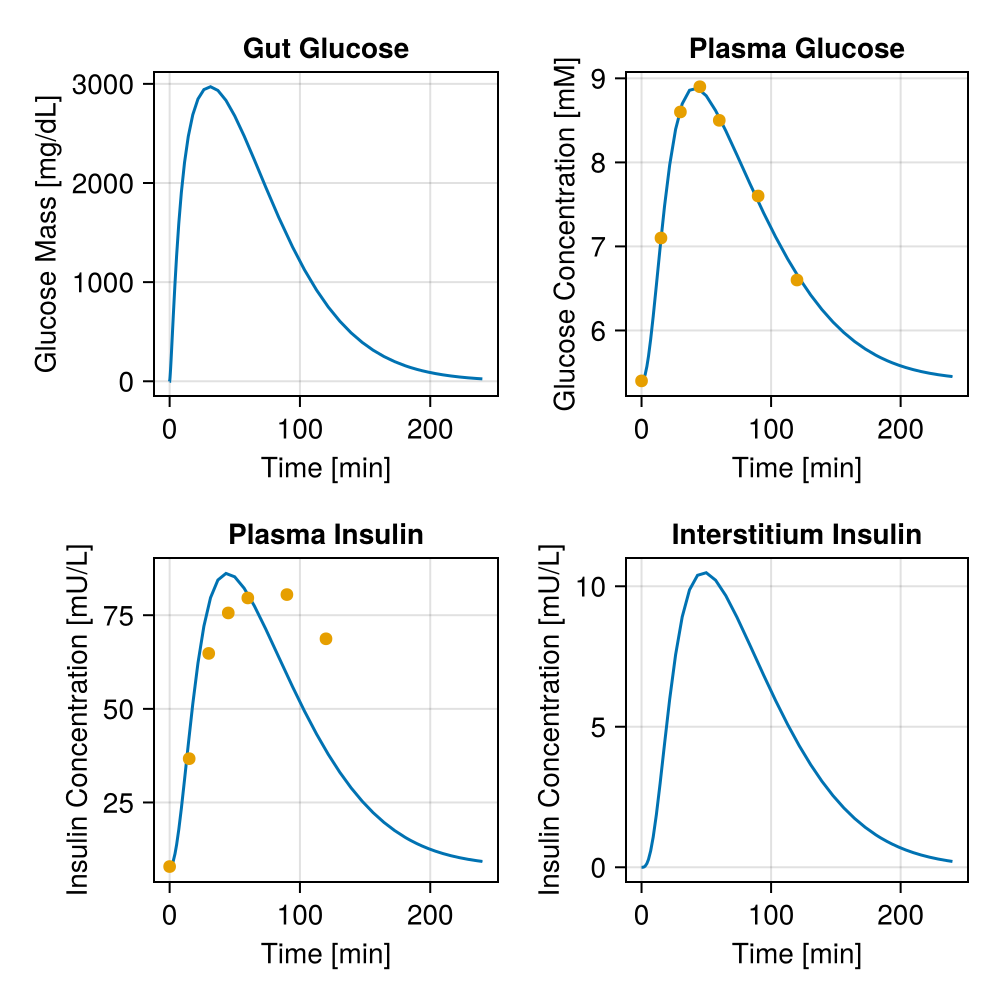

In [63]:

# visualize the solution against the data
solution_figure = let f = Figure(size=(500,500))

    ax_g_gut = Axis(f[1,1], xlabel="Time [min]", ylabel="Glucose Mass [mg/dL]", title="Gut Glucose")
    ax_g_plasma = Axis(f[1,2], xlabel="Time [min]", ylabel="Glucose Concentration [mM]", title="Plasma Glucose")
    ax_i_plasma = Axis(f[2,1], xlabel="Time [min]", ylabel="Insulin Concentration [mU/L]", title="Plasma Insulin")
    ax_i_int = Axis(f[2,2], xlabel="Time [min]", ylabel="Insulin Concentration [mU/L]", title="Interstitium Insulin")
  
    lines!(ax_g_gut, solution.t, solution[1,:], color=Makie.wong_colors()[1])
    lines!(ax_g_plasma, solution.t, solution[2,:], color=Makie.wong_colors()[1])
    lines!(ax_i_plasma, solution.t, solution[3,:], color=Makie.wong_colors()[1])
    lines!(ax_i_int, solution.t, solution[4,:], color=Makie.wong_colors()[1])
    
    band!(ax_g_plasma, solution.t, solution[2,:] .+ final[5], solution[2,:] .- final[5])
    band!(ax_i_plasma, solution.t, solution[3,:] .+ final[6], solution[3,:] .- final[6])

    scatter!(ax_i_plasma, data[1,:], data[3,:], color=Makie.wong_colors()[2])
    scatter!(ax_g_plasma, data[1,:], data[2,:], color=Makie.wong_colors()[2])
  
    f
end

As we estimated parameters using a high number of initial values we can also visualise the distrbution of the parameter estimates using a histogram. This can provide insights into our parameter space, indicating if all solutions converge to a single gloabl minimum or if multiple local minima exist for some parameters. There may also be a uniform distribution of solutions for some parameters suggesting we may not be able to idenitfy this parameter from the data. 

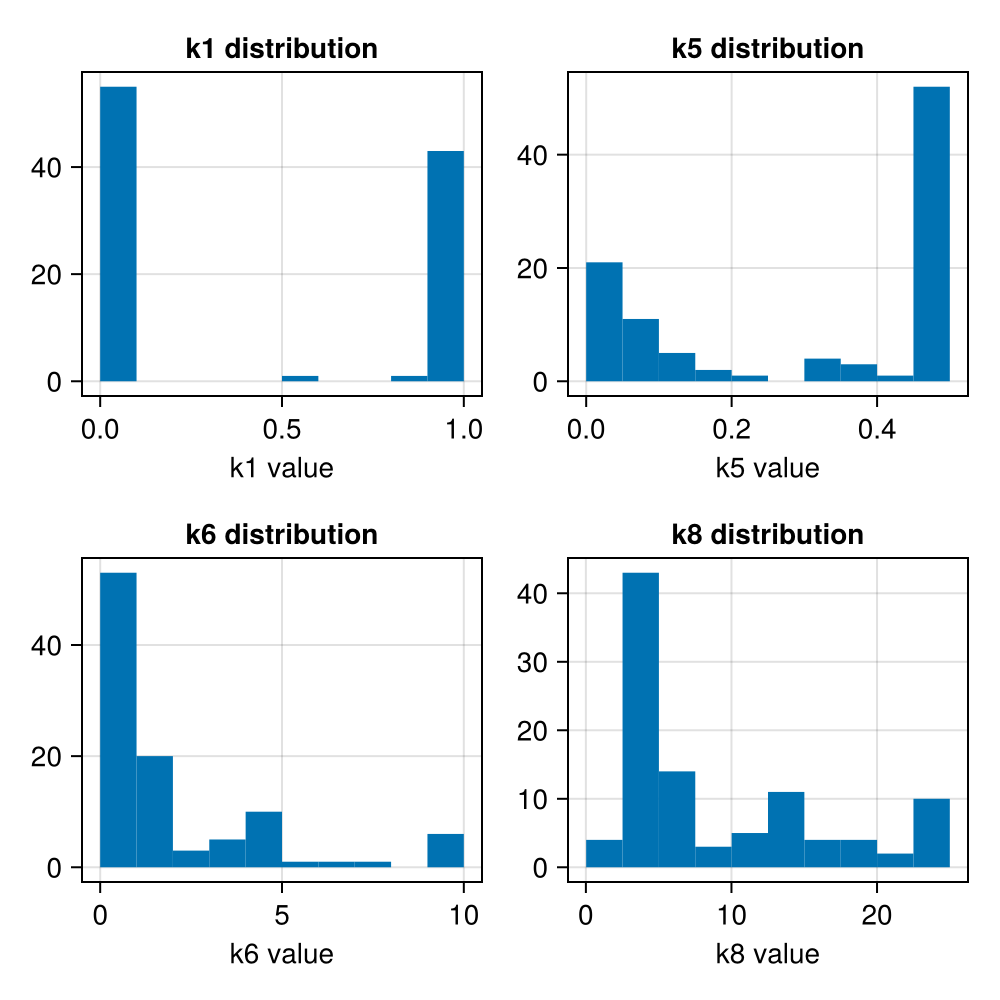

In [64]:
# visualize the histogram of parameter estiamtes for all intiialiaslisations
k1=[]
k5=[]
k6=[]
k8=[]
for r =1:100
  push!(k1,results[r].u[1])
  push!(k5,results[r].u[2])
  push!(k6,results[r].u[3])
  push!(k8,results[r].u[4])
end

solution_figure = let f = Figure(size=(500,500))

    ax_k1 = Axis(f[1,1], xlabel="k1 value", title="k1 distribution")
    ax_k5 = Axis(f[1,2], xlabel="k5 value", title="k5 distribution")
    ax_k6 = Axis(f[2,1], xlabel="k6 value", title="k6 distribution")
    ax_k8 = Axis(f[2,2], xlabel="k8 value", title="k8 distribution")

    hist!(ax_k1, k1, bins=10,color=Makie.wong_colors()[1])
    hist!(ax_k5, k5, bins=10,color=Makie.wong_colors()[1])
    hist!(ax_k6, k6, bins=10,color=Makie.wong_colors()[1])
    hist!(ax_k8, k8, bins=10,color=Makie.wong_colors()[1])
  
    f
  end

What does the distribution of the parameter estimates across the 1000 initital guesses tell us? is there a parameter where all estimates converge to the same local minima or are there multiple local minima? Is there a parameter with a uniform distribution? What would this mean for parameter identifiability? 

## Implementation of Profile Likelihood Analysis

The manual implementation of Profile Likelihood Analysis requires some tricky functions, but it is not too difficult to implement. We will take you through the steps of implementing the Profile Likelihood Analysis for the EDES model.

First define a nice struct that contains the output of a PLA. We will fill this struct later.

In [65]:
struct PLAResult
    likelihood_values
    parameter_values
    optim_index::Int
    other_parameter_values
end

The loss function also needs some modification. We define a constructor for modifying the loss function which returns a new loss function. This new loss function will compute the loss when fixing one of the parameters to a certain value. This is the essence of the Profile Likelihood Analysis. We will also assume the errors are known in this case, so we will not compute the profile likelihoods for the errors, and also not re-estimate them. 

In [66]:
function loss_known_sigma(θ,(problem, constants ,data, sigma_g, sigma_i))
  #measured glucose and insulin data, including the sampling time points
    glucose_data = data[2,:]
    insulin_data = data[3,:]
    data_timepoints = data[1,:]

    #generate the full parameter vector by combining current values for the estimated parameters with the fixed values and constants.
    p = construct_parameters(θ, constants)

    # solve the ode problem for these parameter values
    pred = solve(problem, Tsit5(), p=p, saveat=data_timepoints, save_idxs=[2, 3], u0=[0.0, data[2,1], data[3,1], 0.0])
    sol = Array(pred)

    #calcualte the error between the measured glucose and insulin data and the EDES model simulation
    g_loss=(sol[1,:] - glucose_data)/maximum(glucose_data)
    i_loss=(sol[2,:] - insulin_data)/maximum(insulin_data)
    
    # likelihood for the glucose data
    n = length(glucose_data)
    σ_g = sigma_g
    L_g = n*log(σ_g * sqrt(2π)) + 1/(2σ_g^2) * sum(abs2, g_loss)

    # likelihood for the insulin data
    σ_i = sigma_i
    L_i = n*log(σ_i * sqrt(2π)) + 1/(2σ_i^2) * sum(abs2, i_loss)

    # weighted sum of the likelihoods
    return 0.5 * L_g + 0.5 * L_i
  end

function loss_pla(loss, pla_param, fixed_parameter_value, npar)

    # compute the order of the parameters
    parameter_order = zeros(Int64,npar)
    parameter_order[[1:pla_param-1; (pla_param+1):npar]] .= 1:npar-1
    parameter_order[pla_param] = npar
    
    function _loss_pla(θ, p)
      # construct the full parameter vector
      θ_full = [θ; fixed_parameter_value][parameter_order]
      loss(θ_full, p)
    end
end

loss_pla (generic function with 1 method)

Each PLA step then involves fixing the parameter value to a certain value, defining the loss function to use that fixed value, and then running the optimisation algorithm to find the best parameters for the other parameters. We also define a constructor for doing this, which returns a new function that will run a PLA step.

In [67]:
function pla_step(pla_param_index, loss, θ_init, lb, ub, p)
    npar = length(θ_init)
    lb_pla = [lb[1:pla_param_index-1]; lb[(pla_param_index+1):npar]]
    ub_pla = [ub[1:pla_param_index-1]; ub[(pla_param_index+1):npar]]
    initial_guess = [θ_init[1:pla_param_index-1]; θ_init[pla_param_index+1:end]]

    function _likelihood(pla_param)
        loss_function = loss_pla(loss, pla_param_index, pla_param, length(initial_guess)+1)
        optfunc = OptimizationFunction(loss_function, Optimization.AutoForwardDiff())
        optprob = OptimizationProblem(optfunc, initial_guess, p, lb = lb_pla, ub = ub_pla)

        optsol = solve(optprob, Optimization.LBFGS())
        optsol.objective, optsol.u
    end
end

pla_step (generic function with 1 method)

Finally, we combine this into a function that will run such a PLA step for a parameter iteratively over a range of values and stores the results in the struct we have defined earlier.

In [68]:
function run_pla(pla_param, param_range, param_optim, loss, initial_guess, lb_pla, ub_pla, p)

    # setup PLA likelihood
    step = pla_step(
        pla_param, 
        loss, 
        initial_guess, 
        lb_pla, ub_pla, p
    )

    param_range = sort(unique([param_range; param_optim]))
    optim_index = findfirst(x -> x == param_optim, param_range)
    pla_likelihood_values = Float64[]
    other_parameter_values = typeof(initial_guess)[]
    parameter_values = typeof(param_optim)[]
    for px in param_range
        try
            l, _p = step(px)
            push!(pla_likelihood_values, l)
            push!(other_parameter_values, _p)
            push!(parameter_values, px)
        catch e
            throw(e)
            continue
        end
    end
    
    return PLAResult(pla_likelihood_values, parameter_values, optim_index, other_parameter_values)
end

run_pla (generic function with 1 method)

If we have a nice struct, we can define a function to plot the results of a PLA run for one parameter.

In [69]:
function likelihood_profile!(ax, pla_result::PLAResult, param_index, param_name)
    parameter_values =  pla_result.parameter_values
    likelihood_values = pla_result.likelihood_values .- minimum(pla_result.likelihood_values)
    lines!(ax, parameter_values, likelihood_values, color=Makie.wong_colors()[1])
    #scatter!(ax, parameter_values, likelihood_values, color=Makie.wong_colors()[2])    
end

likelihood_profile! (generic function with 1 method)

## Running the PLA for the EDES model

Now we are ready to run PLA for each parameter. We have configured suitable ranges for each parameter.

In [70]:
# configure pla runs for each parameter
ranges = [
    range(1e-5, 0.05, length=800),
    range(0.001, 0.5, length=800),
    range(0.5, 6.0, length=400),
    range(3.0, 12.0, length=400)
]

pla_results = [
    run_pla(i, ranges[i], final[i], loss_known_sigma, final[1:4], [0.0, 0.0, 0.0, 0.0], [1.0, 0.5, 10.0, 25.0], (prob, constants, data, final[5], final[6])) for i in eachindex(final[1:4])
];

┌ Warning: Unrecognized stop reason: ABNORMAL_TERMINATION_IN_LNSRCH                              . Defaulting to ReturnCode.Default.
└ @ Optimization C:\Users\20195166\.julia\packages\Optimization\qX4vR\src\utils.jl:93
┌ Warning: Unrecognized stop reason: ABNORMAL_TERMINATION_IN_LNSRCH                              . Defaulting to ReturnCode.Default.
└ @ Optimization C:\Users\20195166\.julia\packages\Optimization\qX4vR\src\utils.jl:93
┌ Warning: Unrecognized stop reason: ABNORMAL_TERMINATION_IN_LNSRCH                              . Defaulting to ReturnCode.Default.
└ @ Optimization C:\Users\20195166\.julia\packages\Optimization\qX4vR\src\utils.jl:93
┌ Warning: Unrecognized stop reason: ABNORMAL_TERMINATION_IN_LNSRCH                              . Defaulting to ReturnCode.Default.
└ @ Optimization C:\Users\20195166\.julia\packages\Optimization\qX4vR\src\utils.jl:93
┌ Warning: Unrecognized stop reason: ABNORMAL_TERMINATION_IN_LNSRCH                              . Defaulting to ReturnCode.

We can now visualize the results of the PLA for each parameter. We also visualize a threshold which is based on the 95% quantile of the chi-squared distribution. This theshold does assume an infinite sample case, so it should be interpreted carefully. A correction for finite sample sizes is possible (see [Tönsing et al., 2023](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1011417)), but is not implemented here.

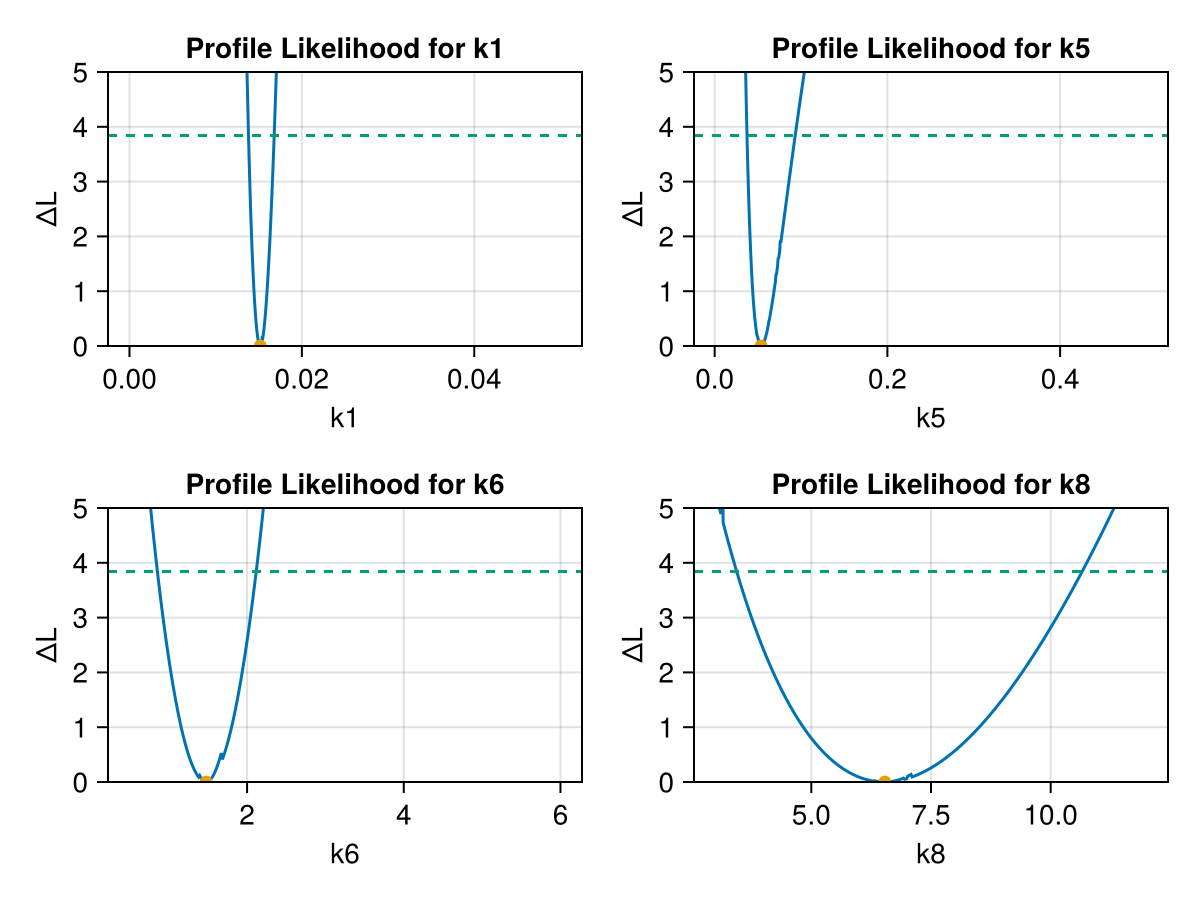

In [71]:
figure_likelihood = let f = Figure()
    positions = [(1,1), (1,2), (2,1), (2,2)]
    for (i, (pos, param_name)) in enumerate(zip(positions, ["k1", "k5", "k6", "k8"]))
        ax = Axis(getindex(f, pos...), xlabel=param_name, ylabel="ΔL", title="Profile Likelihood for $param_name")
        likelihood_profile!(ax, pla_results[i], i, param_name)
        scatter!(ax, [final[i]], [0], color=Makie.wong_colors()[2])
        limit_line = quantile(Chisq(1), 0.95)
        hlines!(ax, [limit_line], linestyle=:dash, color = Makie.wong_colors()[3])
        ylims!(ax, (0.0, 5.0))
    end

    f
end

Are the parameters in the four-parameter EDES model identifiable? Which parameters are non-identifiable? Are they structurally or practically non-identifiable? Is this the same for the average case and the two individuals? What could be done to resolve this non-identifiability?

### Exercise
Fix k8 = 7.25. What is the effect on the parameter estimation? What is the effect on the PLA? Are the paramters now identifiable? 

┌ Warning: Unrecognized stop reason: ABNORMAL_TERMINATION_IN_LNSRCH                              . Defaulting to ReturnCode.Default.
└ @ Optimization C:\Users\20195166\.julia\packages\Optimization\qX4vR\src\utils.jl:93
┌ Warning: Unrecognized stop reason: ABNORMAL_TERMINATION_IN_LNSRCH                              . Defaulting to ReturnCode.Default.
└ @ Optimization C:\Users\20195166\.julia\packages\Optimization\qX4vR\src\utils.jl:93
┌ Warning: Unrecognized stop reason: ABNORMAL_TERMINATION_IN_LNSRCH                              . Defaulting to ReturnCode.Default.
└ @ Optimization C:\Users\20195166\.julia\packages\Optimization\qX4vR\src\utils.jl:93
┌ Warning: Unrecognized stop reason: ABNORMAL_TERMINATION_IN_LNSRCH                              . Defaulting to ReturnCode.Default.
└ @ Optimization C:\Users\20195166\.julia\packages\Optimization\qX4vR\src\utils.jl:93
┌ Warning: Unrecognized stop reason: ABNORMAL_TERMINATION_IN_LNSRCH                              . Defaulting to ReturnCode.

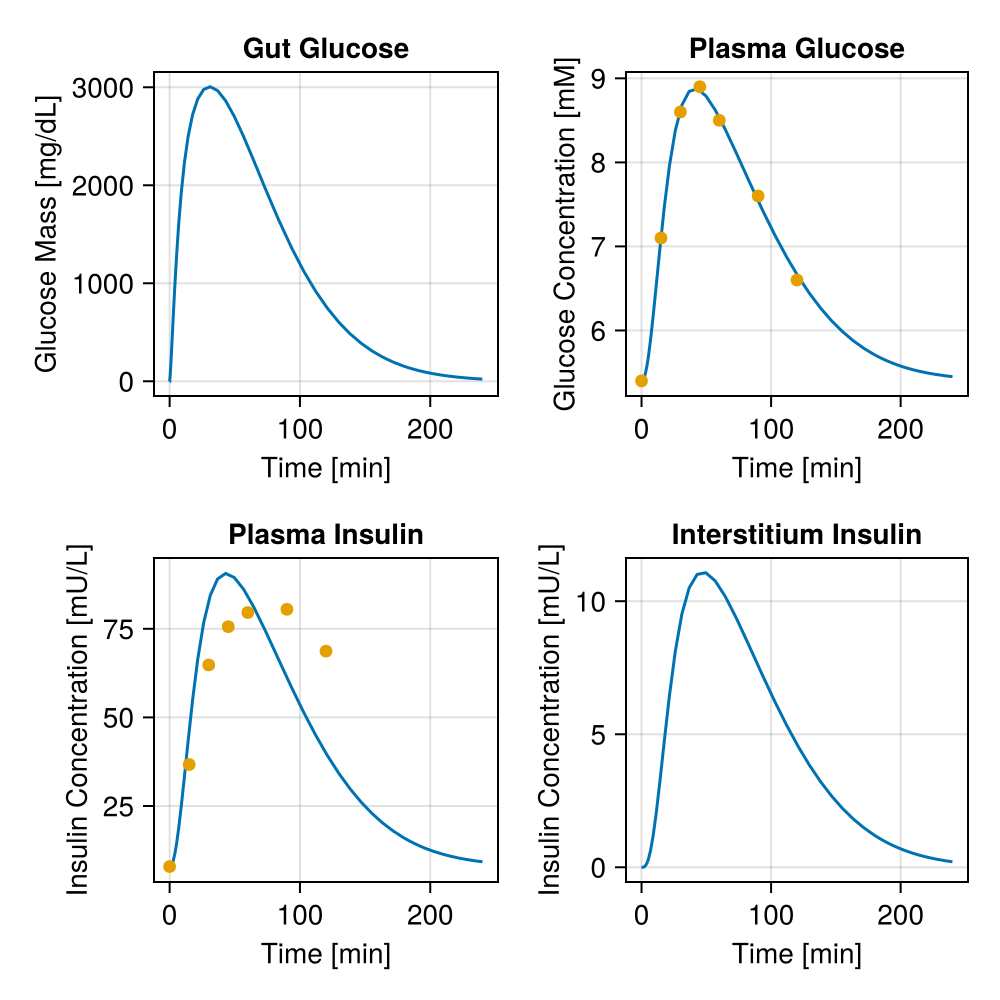

In [78]:
#below is the solution for fixing the value of the k8 parameter to 7.25. 
#This solution outlines the changes you need to make to the code to estimate 3 parameter rather than 4 (including specifing upper and lower bound for each estiamted parameter)

#firstly, we go to the construc_parameters function and fix k8 = 7.25
    function construct_parameters(θ, c)
    
        # Estimated parameters
        k1 = θ[1]     # rate og glucose decay in stomach
        k5 = θ[2]     # rate of insulin dependent glucose uptake into peripheral tissues
        k6 = θ[3]     # rate of insulin secretion (proportional to Gb)
        k8 = 7.25     # rate of insulin secretion (derivative of Gpl) #to fix the value for k8 you can change the value here (an example is provided below)
        
        # Fixed parameters
        k2 = c[1]     # rate of glcuose transport from stomach to plasma
        k3 = c[2]     # rate of glucose effect on endogenous glucose production
        k4 = c[3]     # rate of insulin effect on endogenous glucose production
        k7 = c[4]     # rate of insulin secretion (integral of Gpl)
        k9 = c[5]     # delay parameter plasma to insterstitial insulin
        k10 = c[6]    # rate constant for degredation of insulin in remote compartment
        tau_i = c[7]  # time delay integrator function
        tau_d = c[8]  # time delay 
        beta = c[9]   # conversion factor insulin
        Gren = c[10]  # threshold for renal excretion of glucose
        EGPb = c[11]  # basal rate of endogenous glucose production
        Km = c[12]    # Michealis Menten coeficient for glucose uptake into periphery
        f = c[13]     #
        Vg = c[14]    # volume of distribution for glucose (function of body weight)
        c1 = c[15]    # model constant
        sigma = c[16] # shape factor (appearance of meal)
        Dmeal = c[17] #amount of glucose in meal (mg)
        bw = c[18]    #body weight (kg)
        Gb = c[19]    #fasting glucose (mmol/l)
        Ib = c[20]    #fasting insulin (uIU/ml)
        return [k1, k2, k3, k4, k5, k6, k7, k8, k9, k10, tau_i, tau_d, beta, Gren, EGPb, Km, f, Vg, c1, sigma, Dmeal, bw, Gb, Ib]
      end

#now generate the inital parameter guesses, in this case we provide only the upper and lower bounds for k1, k5, and k6. 
initial_guess = generate_initial_guesses(1000, [0., 0., 0.,1e-4, 1e-4], [1., 0.5, 5.,100.0,100.0])


results = []
# now run the local optimisation for each initial guess
#
# note: here it is not unusual to get errors or warnings as for some combinations of parameters generatined by the generate_initial_guesses function can induce errors in the ODE solver and/or
# the optimisation algorithm by reaching a tolerance that induces a stop. By making use of the try-catch fundtion the loop with catch the error and continute to the next initial guess. 
# This is also why we use many initial values, as we expect some parameter combinations to be unsuccessful. If you get an error for every parameter combination remove the try-catch and investigate
# if there is an error in your model code. 
for guess in eachcol(initial_guess)
  try
    res = solve(OptimizationProblem(optf, vec(guess), (prob, constants, data), lb = [0,0,0,1e-4, 1e-4], ub=[1,0.5,10, 100, 100]), Optimization.LBFGS())
    push!(results, res)
  catch
    continue
  end
end;

# find the parameterisation with the lowest cost/objective funtion value
best_index = argmin([r.objective for r in results])
final = results[best_index].u

#solve the ODE problem using the solve function - to get the model simulation for this parameter set
solution = solve(prob, p =construct_parameters(final, constants), u0=[0.0, data[2,1], data[3,1], 0.0]);   

# visualize the solution against the data
solution_figure = let f = Figure(size=(500,500))

  ax_g_gut = Axis(f[1,1], xlabel="Time [min]", ylabel="Glucose Mass [mg/dL]", title="Gut Glucose")
  ax_g_plasma = Axis(f[1,2], xlabel="Time [min]", ylabel="Glucose Concentration [mM]", title="Plasma Glucose")
  ax_i_plasma = Axis(f[2,1], xlabel="Time [min]", ylabel="Insulin Concentration [mU/L]", title="Plasma Insulin")
  ax_i_int = Axis(f[2,2], xlabel="Time [min]", ylabel="Insulin Concentration [mU/L]", title="Interstitium Insulin")

  lines!(ax_g_gut, solution.t, solution[1,:], color=Makie.wong_colors()[1])
  lines!(ax_g_plasma, solution.t, solution[2,:], color=Makie.wong_colors()[1])
  lines!(ax_i_plasma, solution.t, solution[3,:], color=Makie.wong_colors()[1])
  lines!(ax_i_int, solution.t, solution[4,:], color=Makie.wong_colors()[1])
  
  band!(ax_g_plasma, solution.t, solution[2,:] .+ final[end-1], solution[2,:] .- final[end-1])
  band!(ax_i_plasma, solution.t, solution[3,:] .+ final[end], solution[3,:] .- final[end])

  scatter!(ax_i_plasma, data[1,:], data[3,:], color=Makie.wong_colors()[2])
  scatter!(ax_g_plasma, data[1,:], data[2,:], color=Makie.wong_colors()[2])

  f
end

┌ Warning: Unrecognized stop reason: ABNORMAL_TERMINATION_IN_LNSRCH                              . Defaulting to ReturnCode.Default.
└ @ Optimization C:\Users\20195166\.julia\packages\Optimization\qX4vR\src\utils.jl:93
┌ Warning: Unrecognized stop reason: ABNORMAL_TERMINATION_IN_LNSRCH                              . Defaulting to ReturnCode.Default.
└ @ Optimization C:\Users\20195166\.julia\packages\Optimization\qX4vR\src\utils.jl:93
┌ Warning: Unrecognized stop reason: ABNORMAL_TERMINATION_IN_LNSRCH                              . Defaulting to ReturnCode.Default.
└ @ Optimization C:\Users\20195166\.julia\packages\Optimization\qX4vR\src\utils.jl:93
┌ Warning: Unrecognized stop reason: ABNORMAL_TERMINATION_IN_LNSRCH                              . Defaulting to ReturnCode.Default.
└ @ Optimization C:\Users\20195166\.julia\packages\Optimization\qX4vR\src\utils.jl:93
┌ Warning: Unrecognized stop reason: ABNORMAL_TERMINATION_IN_LNSRCH                              . Defaulting to ReturnCode.

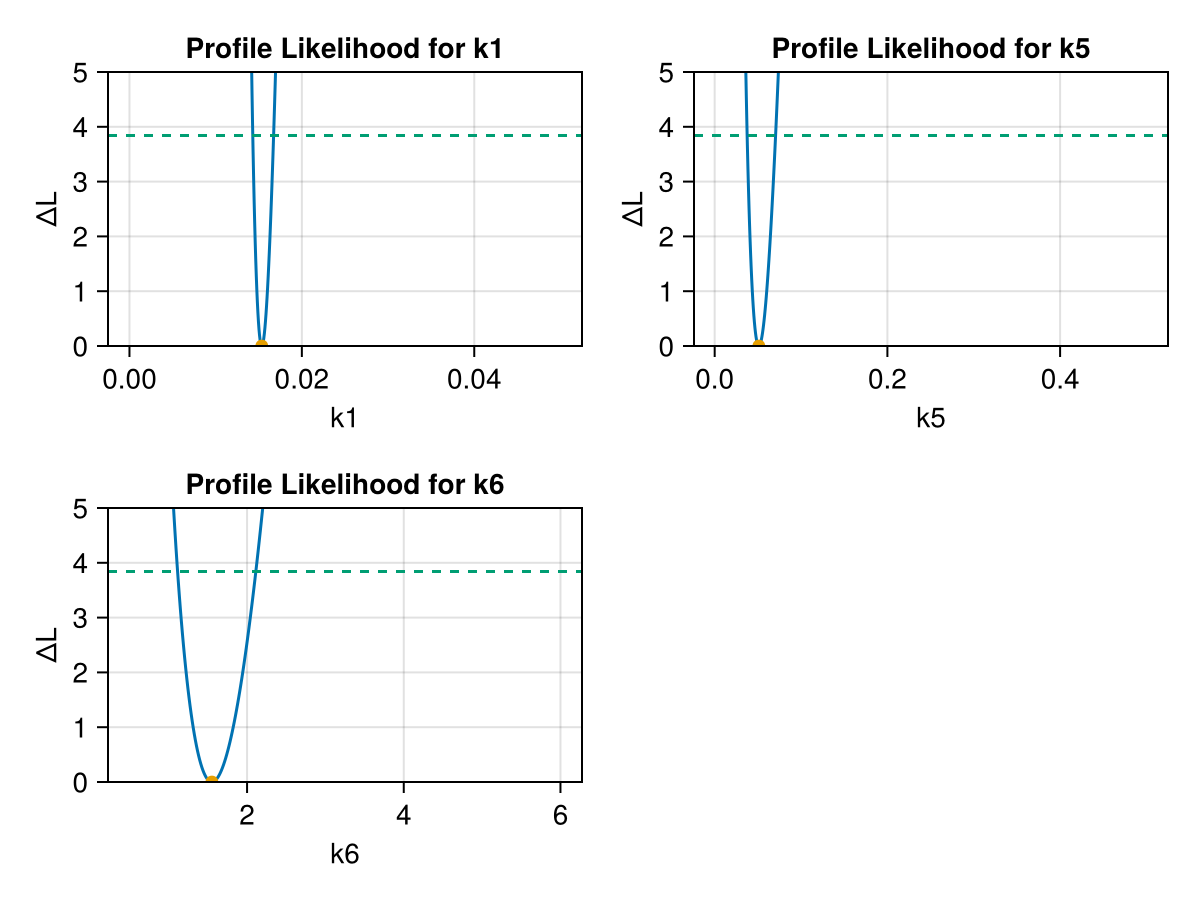

In [86]:
#configure pla runs for each parameter
    ranges = [
        range(1e-5, 0.05, length=800),
        range(0.001, 0.5, length=800),
        range(0.5, 6.0, length=400),

    ]
    
    pla_results = [
        run_pla(i, ranges[i], final[i], loss_known_sigma, final[1:3], [0.0, 0.0, 0.0], [1.0, 0.5, 10.0], (prob, constants, data, final[end-1], final[end])) for i in eachindex(final[1:3])
    ];

    figure_likelihood = let f = Figure()
        positions = [(1,1), (1,2), (2,1)]
        for (i, (pos, param_name)) in enumerate(zip(positions, ["k1", "k5", "k6"]))
            ax = Axis(getindex(f, pos...), xlabel=param_name, ylabel="ΔL", title="Profile Likelihood for $param_name")
            likelihood_profile!(ax, pla_results[i], i, param_name)
            scatter!(ax, [final[i]], [0], color=Makie.wong_colors()[2])
            limit_line = quantile(Chisq(1), 0.95)
            hlines!(ax, [limit_line], linestyle=:dash, color = Makie.wong_colors()[3])
            ylims!(ax, (0.0, 5.0))
        end
    
        f
    end

# Extending EDES with data from wearable sensors

For most individual the three parameter EDES modlel was identifiable given seven venous measurments of glucose and insulin. However, for some individuals, particulary those with faster glucose responses the discrete venous sampling in the standard OGTT often missed essential dynamics and not all parameters were practically non-identifiable. In recent years there has been considerable advancements in wearable flash glucose or continous glucose monitors, which quantify interstitial glucose levels every five mintes. This more freqently sampling has the potential to resolve the issues we have with practical non-identifiabiliy. 

### Exercise
Modify the parameter estimation procedure for the EDES model to work with the CGM glucose data provided below. (Hint: adjust the error function to be dependant only on CGM glucose values - no insulin). Evalute is the EDES model parameters are identifiable using only the CGM data. 

In [ ]:
# mean venous glucose and invsulin values measured during an OGTT
venous_glu = [5.4 7.1 8.6 8.9 8.5 7.6 6.6]
venous_ins = [7.9 36.7 64.8 75.6 79.6 80.5 68.7]
venous_time = [0 15 30 45 60 90 120]
venous_data = [venous_time;venous_glu;venous_ins]
#mean intersitial glucose measured using a CGM device during an OGTT
CGM_glu = [6.1 6.2 6.4 6.7 7.1 7.6 8.1 8.5 8.9 9.2 9.4 9.5 9.6 9.6 9.5 9.4 9.3 9.2 9.0 8.9 8.8 8.6 8.5 8.3 8.2 7.9]
CGM_time = [0	5	10	15	20	25	30	35	40	45	50	55	60	65	70	75	80	85	90	95	100	105	110	115	120	125]
CGM_ins = [7.9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] #the ODE solver needs fasting insulin to run, so I provide this value and zero for the remaining time point (will not be includedv in the error)
CGM_data = [CGM_time;CGM_glu;CGM_ins]

3×26 Matrix{Float64}:
 0.0  5.0  10.0  15.0  20.0  25.0  30.0  …  105.0  110.0  115.0  120.0  125.0
 6.1  6.2   6.4   6.7   7.1   7.6   8.1       8.6    8.5    8.3    8.2    7.9
 7.9  0.0   0.0   0.0   0.0   0.0   0.0       0.0    0.0    0.0    0.0    0.0

┌ Warning: Unrecognized stop reason: ABNORMAL_TERMINATION_IN_LNSRCH                              . Defaulting to ReturnCode.Default.
└ @ Optimization C:\Users\20195166\.julia\packages\Optimization\qX4vR\src\utils.jl:93
┌ Warning: Unrecognized stop reason: ABNORMAL_TERMINATION_IN_LNSRCH                              . Defaulting to ReturnCode.Default.
└ @ Optimization C:\Users\20195166\.julia\packages\Optimization\qX4vR\src\utils.jl:93
┌ Warning: Unrecognized stop reason: ABNORMAL_TERMINATION_IN_LNSRCH                              . Defaulting to ReturnCode.Default.
└ @ Optimization C:\Users\20195166\.julia\packages\Optimization\qX4vR\src\utils.jl:93
┌ Warning: Unrecognized stop reason: ABNORMAL_TERMINATION_IN_LNSRCH                              . Defaulting to ReturnCode.Default.
└ @ Optimization C:\Users\20195166\.julia\packages\Optimization\qX4vR\src\utils.jl:93
┌ Warning: Unrecognized stop reason: ABNORMAL_TERMINATION_IN_LNSRCH                              . Defaulting to ReturnCode.

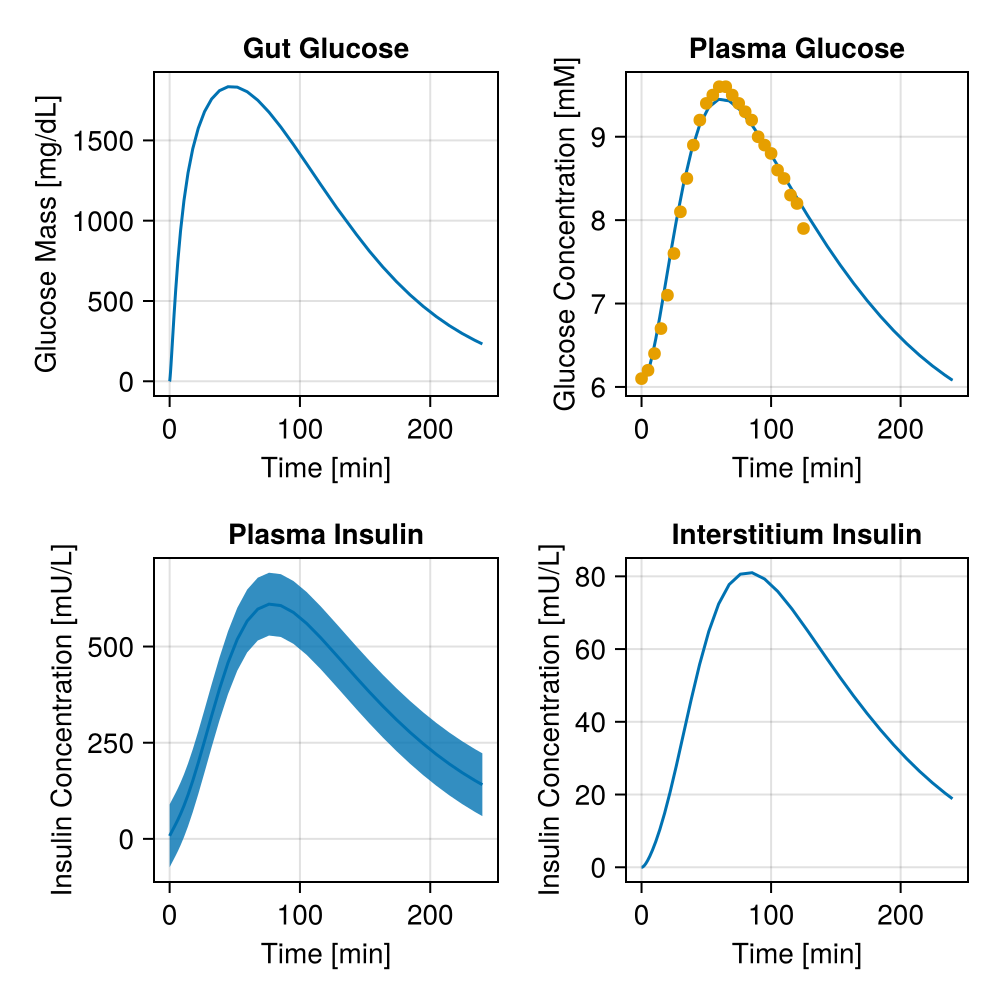

In [102]:
#solution
#
#First we fit the EDES model to the CGM data. To do this we adjust the loss function to use only the glucose error
#define our loss function
#
#loss function takes in values for the estimated parameter and a tuple containing the ODE problem name, values for the fixed parameters and model constants, and the measured experimetnal data. 
function loss_CGM(θ,(problem, constants ,data))
    #measured glucose and insulin data, including the sampling time points
      glucose_data = data[2,:]
      data_timepoints = data[1,:]
  
      #generate the full parameter vector by combining current values for the estimated parameters with the fixed values and constants.
      p = construct_parameters(θ, constants)
  
      # solve the ode problem for these parameter values, in this function we define the parameters as p
      # We also only save the ODE simulation at the timepoints that corrispond to the measured glucose and insulin data so we can calculate the error.
      # we also specify that of the four state varaibles [G_gut,  G_pl, I_pl, I_d] for calculating the error we are only interested in G_pl and I_pl 
      # we also specify the initial values (U0) for each state variable ([G_gut,G_pl,I_pl,I_d])  for the ODE solver
      pred = solve(problem, Tsit5(), p=p, saveat=data_timepoints, save_idxs=[2], u0=[0.0, data[2,1], data[3,1], 0.0])
      sol = Array(pred)
  
      #calcualte the error between the measured glucose and insulin data and the EDES model simulation
      g_loss=(sol[1,:] - glucose_data)/maximum(glucose_data)
      
      # likelihood for the glucose data
      n = length(glucose_data)
      σ_g = θ[end-1]
      L_g = n*log(σ_g * sqrt(2π)) + 1/(2σ_g^2) * sum(abs2, g_loss)
  
      # weighted sum of the likelihoods
      return 0.5 * L_g
    end
#we then run the parameter estimation with the new loss function for the three parameter EDES model (k1,k5,k6)
#we first define a new optfunction that directs the optimisation to our new loss function
optf = OptimizationFunction(loss_CGM, AutoForwardDiff())
    results = [] 
    for guess in eachcol(initial_guess)
      try
        res = solve(OptimizationProblem(optf, vec(guess), (prob, constants, CGM_data), lb = [0,0,0,1e-4, 1e-4], ub=[1,0.5,10, 100, 100]), Optimization.LBFGS())
        push!(results, res)
      catch
        continue
      end
    end;
    
    # find the parameterisation with the lowest cost/objective funtion value
    best_index = argmin([r.objective for r in results])
    final = results[best_index].u
    
    #solve the ODE problem using the solve function - to get the model simulation for this parameter set
    solution = solve(prob, p =construct_parameters(final, constants), u0=[0.0, CGM_data[2,1], 7.9, 0.0]);   
    
    # visualize the solution against the data
    solution_figure = let f = Figure(size=(500,500))
    
      ax_g_gut = Axis(f[1,1], xlabel="Time [min]", ylabel="Glucose Mass [mg/dL]", title="Gut Glucose")
      ax_g_plasma = Axis(f[1,2], xlabel="Time [min]", ylabel="Glucose Concentration [mM]", title="Plasma Glucose")
      ax_i_plasma = Axis(f[2,1], xlabel="Time [min]", ylabel="Insulin Concentration [mU/L]", title="Plasma Insulin")
      ax_i_int = Axis(f[2,2], xlabel="Time [min]", ylabel="Insulin Concentration [mU/L]", title="Interstitium Insulin")
    
      lines!(ax_g_gut, solution.t, solution[1,:], color=Makie.wong_colors()[1])
      lines!(ax_g_plasma, solution.t, solution[2,:], color=Makie.wong_colors()[1])
      lines!(ax_i_plasma, solution.t, solution[3,:], color=Makie.wong_colors()[1])
      lines!(ax_i_int, solution.t, solution[4,:], color=Makie.wong_colors()[1])
      
      band!(ax_g_plasma, solution.t, solution[2,:] .+ final[end-1], solution[2,:] .- final[end-1])
      band!(ax_i_plasma, solution.t, solution[3,:] .+ final[end], solution[3,:] .- final[end])
    
      
      scatter!(ax_g_plasma, CGM_data[1,:], CGM_data[2,:], color=Makie.wong_colors()[2])
    
      f
    end

In [101]:
final

5-element Vector{Float64}:
  0.009245296515144604
  0.001315335951213641
 20.0
  0.011518597897083274
 40.250059750000005

┌ Warning: Unrecognized stop reason: ABNORMAL_TERMINATION_IN_LNSRCH                              . Defaulting to ReturnCode.Default.
└ @ Optimization C:\Users\20195166\.julia\packages\Optimization\qX4vR\src\utils.jl:93
┌ Warning: Unrecognized stop reason: ABNORMAL_TERMINATION_IN_LNSRCH                              . Defaulting to ReturnCode.Default.
└ @ Optimization C:\Users\20195166\.julia\packages\Optimization\qX4vR\src\utils.jl:93
┌ Warning: Unrecognized stop reason: ABNORMAL_TERMINATION_IN_LNSRCH                              . Defaulting to ReturnCode.Default.
└ @ Optimization C:\Users\20195166\.julia\packages\Optimization\qX4vR\src\utils.jl:93
┌ Warning: Unrecognized stop reason: ABNORMAL_TERMINATION_IN_LNSRCH                              . Defaulting to ReturnCode.Default.
└ @ Optimization C:\Users\20195166\.julia\packages\Optimization\qX4vR\src\utils.jl:93
┌ Warning: Unrecognized stop reason: ABNORMAL_TERMINATION_IN_LNSRCH                              . Defaulting to ReturnCode.

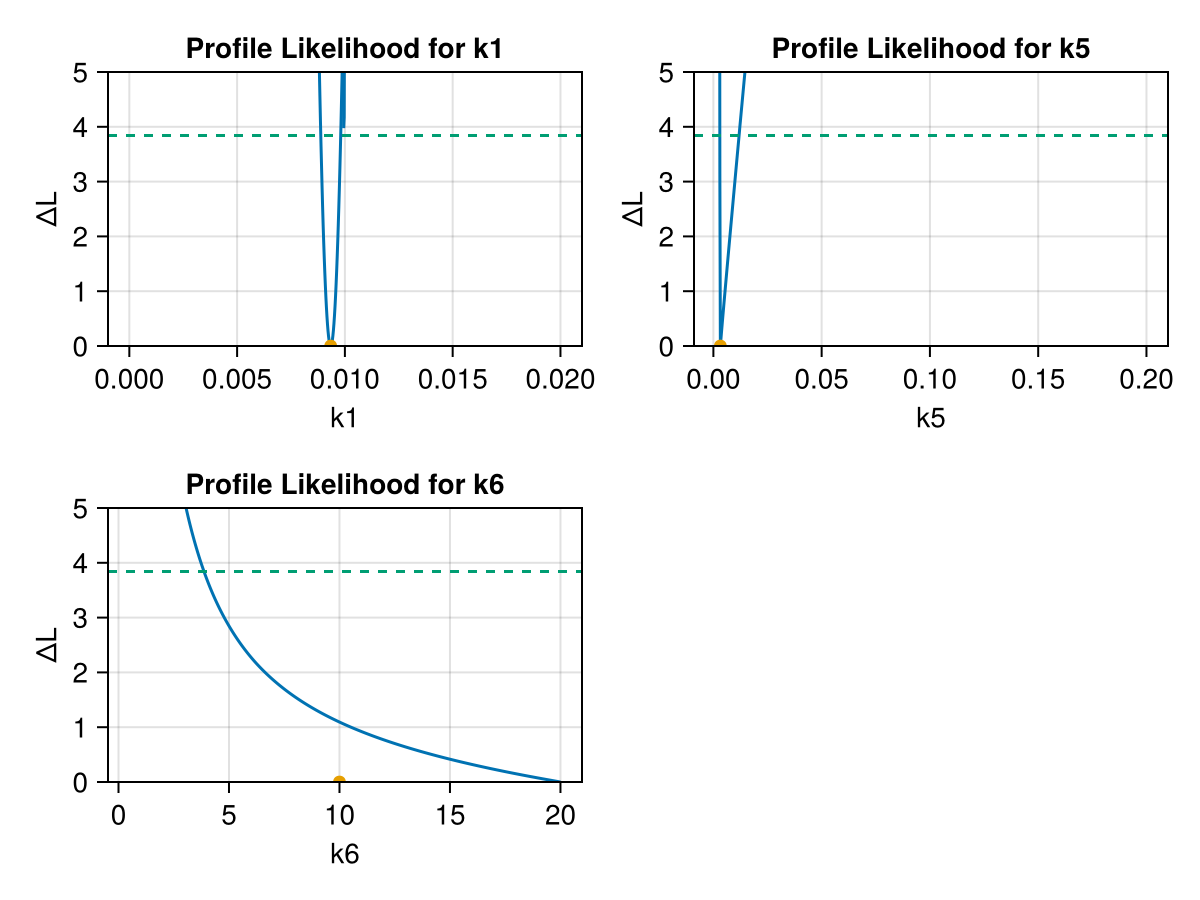

In [103]:
#The we run PLA for the three parameter EDES model fit to CGM glucose data only. 
#
#Again, the first thing we do is modify the PLA loss function to use only CGM glucose (no insulin)
function loss_known_sigma_CGM(θ,(problem, constants ,data, sigma_g, sigma_i))
    #measured glucose and insulin data, including the sampling time points
      glucose_data = data[2,:]
      insulin_data = data[3,:]
      data_timepoints = data[1,:]
  
      #generate the full parameter vector by combining current values for the estimated parameters with the fixed values and constants.
      p = construct_parameters(θ, constants)
  
      # solve the ode problem for these parameter values
      pred = solve(problem, Tsit5(), p=p, saveat=data_timepoints, save_idxs=[2], u0=[0.0, data[2,1], data[3,1], 0.0])
      sol = Array(pred)
  
      #calcualte the error between the measured glucose and insulin data and the EDES model simulation
      g_loss=(sol[1,:] - glucose_data)/maximum(glucose_data)
    
      
      # likelihood for the glucose data
      n = length(glucose_data)
      σ_g = sigma_g
      L_g = n*log(σ_g * sqrt(2π)) + 1/(2σ_g^2) * sum(abs2, g_loss)
  
  
      # weighted sum of the likelihoods
      return 0.5 * L_g
    end
  
 
#configure pla runs for each parameter
ranges = [
    range(1e-5, 0.02, length=800),
    range(0.001, 0.2, length=800),
    range(0.5, 20.0, length=400),

]

pla_results = [
    run_pla(i, ranges[i], final[i], loss_known_sigma_CGM, final[1:3], [0.0, 0.0, 0.0], [1.0, 0.5, 10.0], (prob, constants, CGM_data, final[end-1], final[end])) for i in eachindex(final[1:3])
];

figure_likelihood = let f = Figure()
    positions = [(1,1), (1,2), (2,1)]
    for (i, (pos, param_name)) in enumerate(zip(positions, ["k1", "k5", "k6"]))
        ax = Axis(getindex(f, pos...), xlabel=param_name, ylabel="ΔL", title="Profile Likelihood for $param_name")
        likelihood_profile!(ax, pla_results[i], i, param_name)
        scatter!(ax, [final[i]], [0], color=Makie.wong_colors()[2])
        limit_line = quantile(Chisq(1), 0.95)
        hlines!(ax, [limit_line], linestyle=:dash, color = Makie.wong_colors()[3])
        ylims!(ax, (0.0, 5.0))
    end

    f
end